In [1]:
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import feature_extraction
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import string


In [2]:
# Read the data
text_df = pd.read_csv('./website_classification.csv')

In [3]:
# Drop unnecessary columns
text_df.drop(columns=['Unnamed: 0', 'website_url'], inplace=True)

In [4]:
# Remove rows with categories 'Forums' and 'Adult'
# text_df = text_df[~text_df['Category'].isin(['Forums', 'Adult'])]

In [5]:
# Calculate number of unique rows by category
cat_unique_val = text_df.groupby('Category')['cleaned_website_text'].nunique().sort_values(ascending=False)

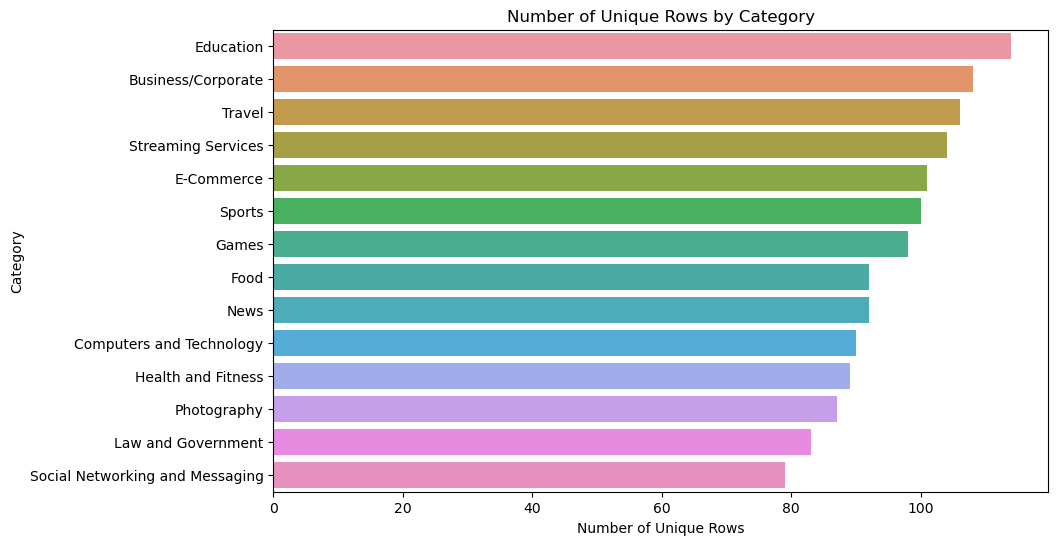

In [6]:

# Visualize number of unique rows by category
plt.figure(figsize=(10, 6))
sns.barplot(x=cat_unique_val.values, y=cat_unique_val.index)
plt.xlabel('Number of Unique Rows')
plt.ylabel('Category')
plt.title('Number of Unique Rows by Category')
plt.show()

In [7]:
# Remove duplicates
text_df.drop_duplicates(inplace=True)

In [8]:
# Text cleaning
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

In [9]:
def text_preprocessing(text):
    word_tokens = word_tokenize(text.lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w not in punctuations]
    return " ".join(filtered_sentence)

In [10]:
text_df['cleaned_website_text'] = text_df['cleaned_website_text'].apply(text_preprocessing)

In [11]:
# Split data into training and testing sets
X = text_df['cleaned_website_text']
y = text_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', None)  # Placeholder for the model
])

In [24]:


# Define the parameter grid
param_grid = [
    {
        'tfidf__max_features': [500, 1000, 2000],
        'model': [MultinomialNB()],
        'model__alpha': [0.1, 0.5, 1.0]  # Specify alpha for MultinomialNB
    },
    {
        'tfidf__max_features': [500, 1000, 2000],
        'model': [RandomForestClassifier()],
        'model__n_estimators': [100, 200, 300]  # Specify n_estimators for RandomForestClassifier
    },
    {
        'tfidf__max_features': [500, 1000, 2000],
        'model': [SVC()],
        'model__C': [1.0, 10.0, 100.0]  # Specify C for SVC
    }
]


In [25]:

# Perform grid search to find the best parameters and model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', None)]),
             param_grid=[{'model': [MultinomialNB(alpha=0.1)],
                          'model__alpha': [0.1, 0.5, 1.0],
                          'tfidf__max_features': [500, 1000, 2000]},
                         {'model': [RandomForestClassifier()],
                          'model__n_estimators': [100, 200, 300],
                          'tfidf__max_features': [500, 1000, 2000]},
                         {'model': [SVC()], 'model__C': [1.0, 10.0, 100.0],
                          'tfidf__max_features': [500, 1000, 2000]}],
             scoring='accuracy')

In [26]:
# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'model': MultinomialNB(alpha=0.1), 'model__alpha': 0.1, 'tfidf__max_features': 2000}
Best Score:  0.9236209519669638


In [27]:

# Evaluate the best model on the testing set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
                                 precision    recall  f1-score   support

             Business/Corporate       0.92      0.85      0.88        27
       Computers and Technology       0.76      0.87      0.81        15
                     E-Commerce       0.88      0.93      0.90        15
                      Education       0.88      0.95      0.91        22
                           Food       0.86      0.95      0.90        20
                          Games       0.95      0.90      0.92        20
             Health and Fitness       1.00      0.93      0.97        15
             Law and Government       1.00      1.00      1.00        21
                           News       0.72      0.81      0.76        16
                    Photography       1.00      0.89      0.94        19
Social Networking and Messaging       1.00      0.75      0.86        16
                         Sports       0.92      0.96      0.94        25
             Streaming Serv

In [28]:
# Perform cross-validation to get a more robust estimate of the model's performance
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-Validation Scores:")
print(cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores:
[0.87360595 0.91078067 0.91449814 0.9141791  0.83955224]
Mean CV Score: 0.8905232203295789


In [30]:
import joblib

# Save the best model
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

In [33]:
# Load the saved model
loaded_model = joblib.load('best_model.pkl')

In [35]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords



In [36]:
def extract_and_preprocess_text(url):
    # Send a GET request to the URL and retrieve the HTML content
    response = requests.get(url)
    html_content = response.content

    # Create a Beautiful Soup object to parse the HTML
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract the text from the HTML
    text = soup.get_text()

    # Preprocess the text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = text.strip()  # Remove leading/trailing spaces

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join the filtered tokens back into a string
    preprocessed_text = ' '.join(filtered_tokens)

    return preprocessed_text


In [40]:
url = 'https://www.linkedin.com'  # Replace with the URL you want to extract text from
preprocessed_text = extract_and_preprocess_text(url)

In [41]:
category = loaded_model.predict([preprocessed_text])[0]


In [42]:
category

'Business/Corporate'